In [2]:
import vaex
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import time

import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)


## Structure of this notebook

Different sections in this notebook: 

1) Prepare all individual training samples & quality cut spectroscopic parameters.
2) Combine different input training subsamples into one master catalogue.
    - Outside of this notebook: cross-match this catalogue with Gaia in Topcat to get source_id
3) Cross-match the master training sample with the latest Pristine catalogue.

To run code file you need to download the APOGEE parameter file (allStarLite-dr17-synspec_rev1.fits) and the SSPP parameter file (ssppOut-dr9.fits) from the SDSS website. 

## Initial settings

In [9]:
## --------------------------------------------------------------
## set paths for relevant files

## not included with the code:
sdss = '../../../../Otherdata/ssppOut-dr9.fits'
apogee = '../../../../Otherdata/allStarLite-dr17-synspec_rev1.fits'

## included with the code:
pastel = 'samples/pastel_v1.2.fits'
aguado19 = 'samples/Aguado19.csv'
lamost = 'samples/VMP_Li_LAMOST-xmatch-DR8_Federicocuts.csv'
pristineHR_1 = 'samples/Pristine-HRfollowup_Paris.dat'
pristineHR_2 = 'samples/Pristine-HRfollowup_Espadons+GRACES.dat'
bootes = 'samples/Romano+Freb_Bootesmembers_highres.dat'

## ---------------
## resulting sample name

train_all = '../catalogues/TrainingSample_may2023_v4.csv'  
 
## ---------------
## latest CaHK catalogue

## internal Pristine DR cross-matched with Gaia DR3 (can also use the public one but that may miss some of the faintest stars)
cahkcat = '../catalogues/Pristine_merged_detections_all_until_22Bm02_x_DR3.csv'     


# Prepare spectroscopic catalogues

## SDSS

In [10]:
dat_sdss = Table.read(sdss, format='fits')
df_sdss = dat_sdss.to_pandas()

In [11]:
### Column names
df_sdss = df_sdss.assign(survey_neverempty = 'SDSS')
df_sdss = df_sdss.assign(program_neverempty = df_sdss.PROGRAMNAME.str.decode("utf-8"))
df_sdss = df_sdss.assign(flag2 = df_sdss.FLAG.str.decode("utf-8"))
df_sdss = df_sdss.rename(columns={'TEFF_ADOP':'teff_lit', 'LOGG_ADOP':'logg_lit', 'FEH_ADOP':'feh_lit', 
                                 'FEH_ADOP_UNC':'e_feh_lit', 'RA':'ra', 'DEC':'dec'})

## Quality cuts
df_sdss = df_sdss[(df_sdss.SNR > 25) 
                  & (df_sdss.logg_lit.abs() < 10) & (df_sdss.teff_lit.abs() < 7000) & (df_sdss.feh_lit.abs() < 10)
                 & (df_sdss.RV_ADOP_UNC < 10) & (df_sdss.e_feh_lit < 0.2)
                  & ((df_sdss.flag2 == 'nnnnn') | (df_sdss.flag2 == 'nnngn') | (df_sdss.flag2 == 'nnnGn'))
                  & (df_sdss.FEH_ANNRR - df_sdss.feh_lit < 0.5)
                  & (df_sdss.ra < 360)
                  # & (df_sdss.program_neverempty.str.contains('segue') | df_sdss.program_neverempty.str.contains('legacy'))
                 ] 

df_sdss_g = df_sdss[['survey_neverempty','program_neverempty', 'ra','dec',
                 'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]


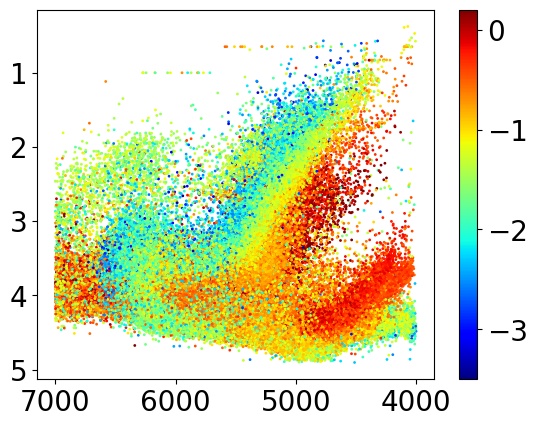

In [12]:
plt.scatter(df_sdss_g.teff_lit, df_sdss_g.logg_lit, c=df_sdss_g.feh_lit, cmap='jet', s=1, rasterized=True, 
           vmin=-3.5, vmax=0.2)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## APOGEE

In [13]:
dat_apo_orig = Table.read(apogee, format='fits')
names = [name for name in dat_apo_orig.colnames if len(dat_apo_orig[name].shape) <= 1]
dat_apo_orig = dat_apo_orig[names].to_pandas()


In [14]:
df_apoc = dat_apo_orig.copy()

In [15]:
## add / update columns
df_apo = dat_apo_orig.copy()
df_apo = df_apo.assign(survey_neverempty = 'APOGEE')
df_apo = df_apo.assign(program_neverempty = df_apo.PROGRAMNAME.str.decode("utf-8"))
df_apo = df_apo.rename(columns={'TEFF':'teff_lit', 'LOGG':'logg_lit', 'FE_H_ERR':'e_feh_lit',
                               'RA':'ra', 'DEC':'dec'})

# the metallicity scale in APOGEE is 0.1 dex off compared to the rest of the training sample, correct for that
df_apo = df_apo.assign(feh_lit = df_apo.FE_H - 0.1)

## quality cuts
df_apo = df_apo[(df_apo.SNR > 50) & (df_apo.feh_lit > -3) & (df_apo.feh_lit < 1.0) & (df_apo.FE_H_FLAG == 0)
                & (df_apo.STARFLAGS != df_apo.STARFLAGS)]

# drop duplicates and keep only the higher signal-to-noise ratio stars
df_apo = df_apo.sort_values(by='SNR', ascending=False)
df_apo = df_apo.drop_duplicates(subset='GAIAEDR3_SOURCE_ID', keep='first')

df_apo_g = df_apo[['survey_neverempty','program_neverempty', 'ra','dec',
                 'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]

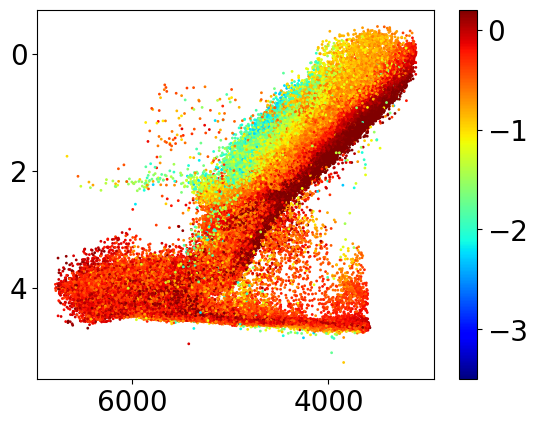

In [16]:
plt.scatter(df_apo_g.teff_lit, df_apo_g.logg_lit, c=df_apo_g.feh_lit, cmap='jet', s=1, rasterized=True, 
           vmin=-3.5, vmax=0.2)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Aguado+19

In [17]:
df_aguado19 = pd.read_csv(aguado19)

In [18]:
## add / update columns
df_aguado19 = df_aguado19.assign(survey_neverempty = 'Aguado19')
df_aguado19 = df_aguado19.assign(program_neverempty = 'FERRE')
df_aguado19 = df_aguado19.assign(SNR = 20)
df_aguado19 = df_aguado19.assign(epoch = 20)
df_aguado19 = df_aguado19.rename(columns={'temp_FERRE':'teff_lit', 'logg_FERRE':'logg_lit', 'FeH_FERRE':'feh_lit',
                                          'FeH_FERRE_err':'e_feh_lit'})

## quality cuts
df_aguado19 = df_aguado19[(df_aguado19.q_flag == 'X')]

df_aguado19_g = df_aguado19[['survey_neverempty','program_neverempty', 'ra','dec',
                 'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]

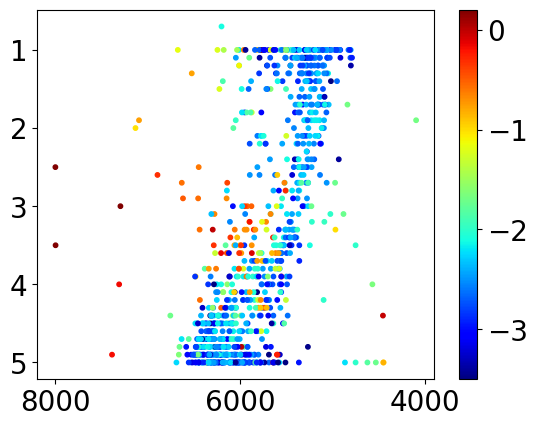

In [19]:
plt.scatter(df_aguado19_g.teff_lit, df_aguado19_g.logg_lit, c=df_aguado19_g.feh_lit, cmap='jet', s=10, 
           vmin=-3.5, vmax=0.2)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Li/LAMOST

The Li/LAMOST catalogue has been cleaned following Sestito+20, but with LAMOST DR8 instead of DR3. The cuts applied are: 
- Teff_li > 4500 
- feh_dr8 < -1.5 
- (sng > 20 | feh_li > -3.0)

In [20]:
df_lamost = pd.read_csv(lamost)

In [21]:
df_lamost = df_lamost.assign(survey_neverempty = 'LAMOST')
df_lamost = df_lamost.assign(program_neverempty = 'LiSample')

df_lamost = df_lamost.rename(columns={'Teff_li':'teff_lit', 'logg_li':'logg_lit', 'FeH_li':'feh_lit',
                                          'e_FeH_li':'e_feh_lit', 'sng':'SNR','RAdeg':'ra','DEdeg':'dec'})

df_lamost_g = df_lamost[['survey_neverempty','program_neverempty','ra','dec',
                               'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]

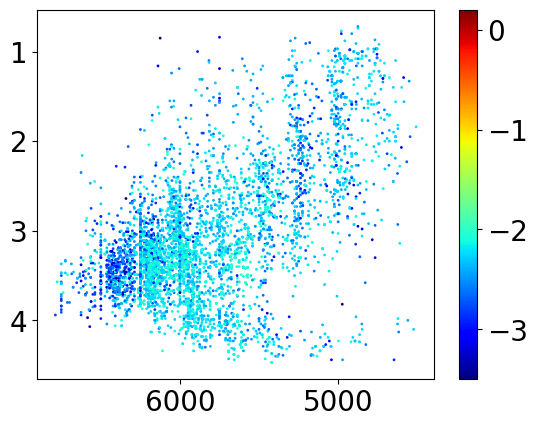

In [22]:
plt.scatter(df_lamost_g.teff_lit, df_lamost_g.logg_lit, c=df_lamost_g.feh_lit, cmap='jet', s=1, rasterized=True, 
           vmin=-3.5, vmax=0.2)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Pristine HR

In [23]:
df_pristineHR_1 = pd.read_csv(pristineHR_1, delim_whitespace=True)
df_pristineHR_1 = df_pristineHR_1.assign(cat = 'Paris')
df_pristineHR_2 = pd.read_csv(pristineHR_2, delim_whitespace=True)
df_pristineHR_2 = df_pristineHR_2.assign(cat = 'Kim')

df_pristineHR = pd.concat([df_pristineHR_1, df_pristineHR_2])

In [24]:
## add/rename columns
df_pristineHR = df_pristineHR.assign(survey_neverempty = 'PristineHR')
df_pristineHR = df_pristineHR.assign(program_neverempty = df_pristineHR.cat)
df_pristineHR = df_pristineHR.assign(SNR = 50)
df_pristineHR = df_pristineHR.rename(columns={'#RA':'ra', 'DEC':'dec', 'Fe':'feh_lit', 'dFe':'e_feh_lit',
                                             'Teff':'teff_lit', 'logg':'logg_lit'})

## set or use later
df_pristineHR_g = df_pristineHR[['survey_neverempty','program_neverempty','ra','dec',
                               'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]

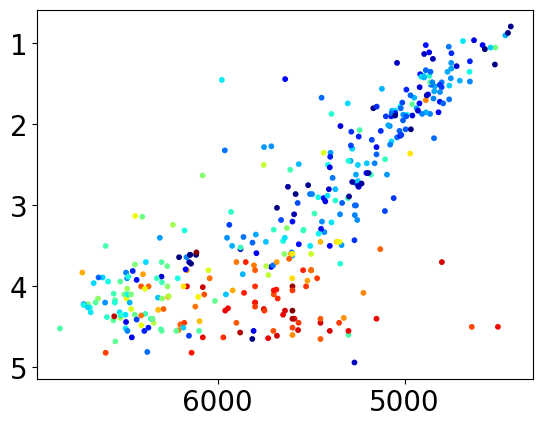

In [25]:
plt.scatter(df_pristineHR_g.teff_lit, df_pristineHR_g.logg_lit, c=df_pristineHR_g.feh_lit, cmap='jet', s=10, 
           vmin=-3.5, vmax=0.2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## Bootes

In [26]:
df_boo1 = pd.read_csv(bootes, delim_whitespace=True)

df_boo1 = df_boo1.assign(survey_neverempty = 'Bootes')
df_boo1 = df_boo1.assign(program_neverempty = 'RomanoFrebel')
df_boo1 = df_boo1.assign(teff_lit = 4800.)
df_boo1 = df_boo1.assign(logg_lit = 1.5)
df_boo1 = df_boo1.assign(SNR = 50)
df_boo1 = df_boo1.rename(columns={'FeH':'feh_lit', 'FeHerr':'e_feh_lit', 'RA':'ra', 'DEC':'dec'})

df_boo1_g = df_boo1[['survey_neverempty','program_neverempty','ra','dec',
                               'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]

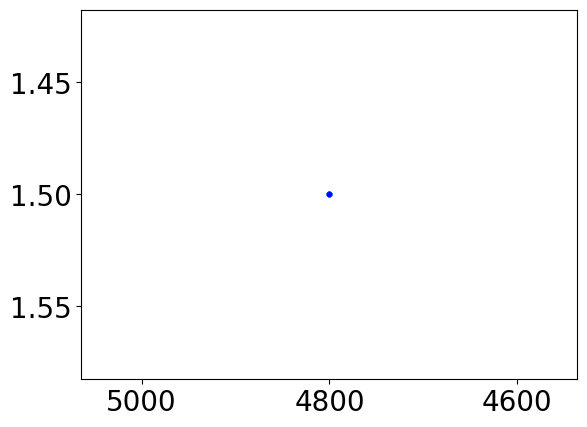

In [27]:
plt.scatter(df_boo1_g.teff_lit, df_boo1_g.logg_lit, c=df_boo1_g.feh_lit, cmap='jet', s=10, 
           vmin=-3.5, vmax=0.2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

## PASTEL

In [28]:
dat_pastel = Table.read(pastel, format='fits')
df_pastel_all = dat_pastel.to_pandas()

In [29]:
df_pastel = df_pastel_all[(df_pastel_all.FEH < -1) & (df_pastel_all.TEFF < 7000)]

df_pastel = df_pastel.assign(survey_neverempty = 'pastel')
df_pastel = df_pastel.assign(program_neverempty = 'hr')
df_pastel = df_pastel.assign(SNR = 50)
df_pastel = df_pastel.assign(e_feh_lit = -99)
df_pastel = df_pastel.rename(columns={'FEH':'feh_lit', 'TEFF':'teff_lit','LOGG':'logg_lit', 'RA':'ra', 'DEC':'dec'})

df_pastel_g = df_pastel[['survey_neverempty','program_neverempty','ra','dec',
                               'teff_lit','logg_lit','feh_lit','e_feh_lit', 'SNR']]

(7500.0, 3000.0)

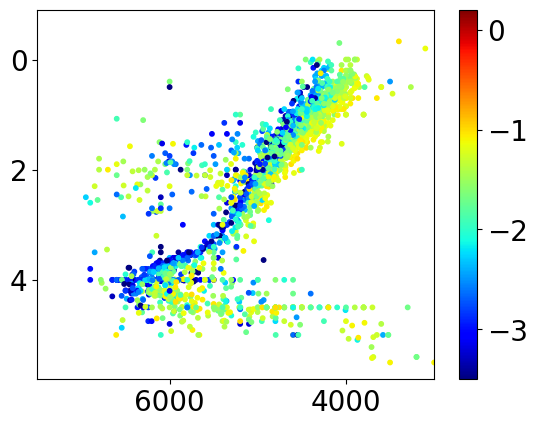

In [30]:
plt.scatter(df_pastel_g.teff_lit, df_pastel_g.logg_lit, c=df_pastel_g.feh_lit, cmap='jet', s=10, 
           vmin=-3.5, vmax=0.2)
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlim(7500,3000)

# Combine all sub-samples

In [31]:
## ordering of the concatenation is important! It will later be used to drop duplicates, keeping the first occurrence

df_TS_both = pd.concat([df_pristineHR_g, df_boo1_g, df_pastel_g, 
                        df_aguado19_g, df_sdss_g, df_lamost_g, 
                        df_apo_g])
df_TS_both.to_csv(train_all, index=None)


# Match with CaHK catalogue

NEXT: create the +source_id file by cross-matching in **Topcat** with Gaia EDR3 J2000 within 1'', keeping only the source_id from Gaia after the cross-match and DITCHING all the other Gaia columns  (!!! important because you don't want to mix up with the Pristine_merged Gaia columns)
 
 
*(could try to code something up to do it here in Python but have not done this for now)*

**Note** :
For the paper training sample we used the internal Pristine data release, which goes deeper than the public one. But the public one can also be used, a small number of stars will be missing. 

In [60]:
traindat = vaex.open(train_all[:-4]+'+source_id.csv')
cahkdat = vaex.open(cahkcat)

In [ ]:
if 'Plx' in list(cahkdat):
    cahkdat.rename('RA','RA_CaHK')
    cahkdat.rename('Dec','Dec_CaHK')
    cahkdat.rename('RAJ2000','ra_epoch2000')
    cahkdat.rename('DEJ2000','dec_epoch2000')
    cahkdat.rename('Source','source_id')
    cahkdat.rename('RAdeg','ra')
    cahkdat.rename('e_RAdeg','ra_error')
    cahkdat.rename('DEdeg','dec')
    cahkdat.rename('e_DEdeg','dec_error')
    cahkdat.rename('Plx','parallax')
    cahkdat.rename('e_Plx','parallax_error')
    cahkdat.rename('RPlx','parallax_over_error')
    cahkdat.rename('PM','pm')
    cahkdat.rename('pmRA','pmra')
    cahkdat.rename('e_pmRA','pmra_error')
    cahkdat.rename('pmDE','pmdec')
    cahkdat.rename('e_pmDE','pmdec_error')
    cahkdat.rename('NgAL','astrometric_n_good_obs_al')
    cahkdat.rename('gofAL','astrometric_gof_al')
    cahkdat.rename('chi2AL','astrometric_chi2_al')
    cahkdat.rename('epsi','astrometric_excess_noise')
    cahkdat.rename('sepsi','astrometric_excess_noise_sig')
    cahkdat.rename('Solved','astrometric_params_solved')
    cahkdat.rename('pscol','pseudocolour')
    cahkdat.rename('e_pscol','pseudocolour_error')
    cahkdat.rename('Nper','visibility_periods_used')
    cahkdat.rename('RUWE','ruwe')
    cahkdat.rename('Dup','duplicated_source')
    cahkdat.rename('FG','phot_g_mean_flux')
    cahkdat.rename('e_FG','phot_g_mean_flux_error')
    cahkdat.rename('Gmag','phot_g_mean_mag')
    cahkdat.rename('FBP','phot_bp_mean_flux')
    cahkdat.rename('e_FBP','phot_bp_mean_flux_error')
    cahkdat.rename('BPmag','phot_bp_mean_mag')
    cahkdat.rename('FRP','phot_rp_mean_flux')
    cahkdat.rename('RPmag','phot_rp_mean_mag')
    cahkdat.rename('E(BP/RP)','phot_bp_rp_excess_factor')
    cahkdat.rename('BP-RP','bp_rp')
    cahkdat.rename('e_Gmag','phot_g_mean_mag_error')
    cahkdat.rename('e_BPmag','phot_bp_mean_mag_error')
    cahkdat.rename('e_RPmag','phot_rp_mean_mag_error')
    cahkdat.rename('e_RAJ2000','ra_epoch2000_error')
    cahkdat.rename('e_DEJ2000','dec_epoch2000_error')
    cahkdat.rename('o_Gmag','phot_g_n_obs')
    cahkdat.rename('RFG','phot_g_mean_flux_over_error')
    cahkdat.rename('o_BPmag','phot_bp_n_obs')
    cahkdat.rename('RFBP','phot_bp_mean_flux_over_error')
    cahkdat.rename('o_RPmag','phot_rp_n_obs')
    cahkdat.rename('e_FRP','phot_rp_mean_flux_error')
    cahkdat.rename('RFRP','phot_rp_mean_flux_over_error')

    cahkdat_new = cahkdat['RA_CaHK',
    'Dec_CaHK',
    'merged_CaHK',
    'merged_d_CaHK',
    'merge_flag',
    'ra_epoch2000',
    'dec_epoch2000',
    'errHalfMaj',
    'errHalfMin',
    'errPosAng',
    'source_id',
    'ra',
    'ra_error',
    'dec',
    'dec_error',
    'parallax',
    'parallax_error',
    'parallax_over_error',
    'pm',
    'pmra',
    'pmra_error',
    'pmdec',
    'pmdec_error',
    'astrometric_n_good_obs_al',
    'astrometric_gof_al',
    'astrometric_chi2_al',
    'astrometric_excess_noise',
    'astrometric_excess_noise_sig',
    'astrometric_params_solved',
    'pseudocolour',
    'pseudocolour_error',
    'visibility_periods_used',
    'ruwe',
    'duplicated_source',
    'phot_g_mean_flux',
    'phot_g_mean_flux_error',
    'phot_g_mean_mag',
    'phot_bp_mean_flux',
    'phot_bp_mean_flux_error',
    'phot_bp_mean_mag',
    'phot_rp_mean_flux',
    'phot_rp_mean_mag',
    'phot_bp_rp_excess_factor',
    'bp_rp',
    'phot_g_mean_mag_error',
    'phot_bp_mean_mag_error',
    'phot_rp_mean_mag_error',
    'ra_epoch2000_error',
    'dec_epoch2000_error',
    'phot_g_n_obs',
    'phot_g_mean_flux_over_error',
    'phot_bp_n_obs',
    'phot_bp_mean_flux_over_error',
    'phot_rp_n_obs',
    'phot_rp_mean_flux_error',
    'phot_rp_mean_flux_over_error',
    'angDist']

In [61]:
df_join = traindat.join(cahkdat_new, 
                        how='left', 
                        left_on ='source_id',
                        right_on='source_id', allow_duplication=True, lsuffix='_train')
df_join = df_join[df_join.merged_CaHK > 0]
test = df_join.extract()

In [62]:
test.export(train_all[:-4]+'+CaHK.csv')